# Welcome to the Deep Learning Example with CoderData

Here we will be using a small subset of the BeatAML data to predict the AUC of drug response values.    
Our predictive variables will be transcriptomics, proteomics, and drug structure.  
This small subset does not have high predictive power and as such, this is just meant as a guide for creating your own models.

#### Import coderdata, pandas and numpy


In [1]:
import pandas as pd
import numpy as np
import coderdata as cd

#### Import keras, the deep learning framework
We will be using the keras functional API. This allows us to use multiple inputs in our model.  
You may need to install a couple of these dependancies to procceed.

In [109]:
import keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#### In this example, we will use a subset of the BeatAML dataset.
The first step is to download the data. We will then import the data into the DatasetLoader object.  
If there are issues with the download process, please ensure that your connection is not blocked by a VPN.

In [7]:
cd.download_data_by_prefix('beataml')
beataml = cd.DatasetLoader("beataml")

Downloaded beataml_drugs.tsv.gz to local repository.
Downloaded beataml_proteomics.csv.gz to local repository.
Downloaded beataml_mutations.csv.gz to local repository.
Downloaded beataml_experiments.csv.gz to local repository.
Downloaded beataml_samples.csv to local repository.
Downloaded beataml_transcriptomics.csv.gz to local repository.
Processing Data...


#### Check Data Information. 
This info command allows us to see which data types are present in the beataml DatasetLoader object.  
We will be using the **Transcriptomics**, **Proteomics**, **Drugs**, and **Experiments** Data in our example.   
In other examples you may want to include the **samples** data to associate cancer and model type with each sample. However, in the BeatAML data, all data is from Acute Myeloid Leukemia patients.

In [5]:
beataml.info()

Dataset Type: beataml
Beat acute myeloid leukemia (BeatAML) data was collected though GitHub and Synapse.

Available Datatypes and Their Formats:
- drugs: Format not specified
- experiments: Format not specified
- mutations: long format
- proteomics: long format
- samples: long format
- transcriptomics: long format


In [6]:
beataml.drugs

,improve_drug_id,chem_name,formula,weight,inCHIKey,canSMILES,isoSMILES
0,SMI_43,17-AAG,C31H43N3O8,585.70,AYUNIORJHRXIBJ-TXHRRWQRSA-N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H]...
1,SMI_3222,A-674563,C22H22N4O,358.40,BPNUQXPIQBZCMR-IBGZPJMESA-N,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...
2,SMI_146,ABT-737,C42H45ClN6O5S2,813.40,HPLNQCPCUACXLM-PGUFJCEWSA-N,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...
3,SMI_57721,AKT Inhibitor IV,C31H27IN4S,614.50,NAYRELMNTQSBIN-UHFFFAOYSA-M,CC[N+]1=C(N(C2=C1C=C(C=C2)C3=NC4=CC=CC=C4S3)C5...,CC[N+]1=C(N(C2=C1C=C(C=C2)C3=NC4=CC=CC=C4S3)C5...
4,SMI_57735,AMPK Inhibitor,C24H25N5O,399.50,XHBVYDAKJHETMP-UHFFFAOYSA-N,C1CCN(CC1)CCOC2=CC=C(C=C2)C3=CN4C(=C(C=N4)C5=C...,C1CCN(CC1)CCOC2=CC=C(C=C2)C3=CN4C(=C(C=N4)C5=C...
...,...,...,...,...,...,...,...
35420,SMI_414,Venetoclax,C45H50ClN7O7S,868.40,LQBVNQSMGBZMKD-UHFFFAOYSA-N,CC1(CCC(=C(C1)C2=CC=C(C=C2)Cl)CN3CCN(CC3)C4=CC...,CC1(CCC(=C(C1)C2=CC=C(C=C2)Cl)CN3CCN(CC3)C4=CC...
35421,SMI_1062,Vismodegib,C19H14Cl2N2O3S,421.30,BPQMGSKTAYIVFO-UHFFFAOYSA-N,CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl...,CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl...
35422,SMI_3146,Volasertib,C34H50N8O3,618.80,SXNJFOWDRLKDSF-XKHVUIRMSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C(C)C)NC3=C(C=C(C=C3)...,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C(C)C)NC3=C(C=C(...
35423,SMI_1137,XAV-939,C14H11F3N2OS,312.31,KLGQSVMIPOVQAX-UHFFFAOYSA-N,C1CSCC2=C1N=C(NC2=O)C3=CC=C(C=C3)C(F)(F)F,C1CSCC2=C1N=C(NC2=O)C3=CC=C(C=C3)C(F)(F)F


In [7]:
beataml.experiments


,source,improve_sample_id,improve_drug_id,study,auc,ic50,ec50,ec50se,r2fit,einf,hs,aac1,auc1,dss1
0,synapse,4634,SMI_43,BeatAML,0.5716,NaN,11.430,0.000,0.0000,0.5716,3.525,0.4284,0.5716,0.3649
1,synapse,4634,SMI_3222,BeatAML,0.6310,NaN,10.890,0.000,-0.0000,0.6310,3.171,0.3690,0.6310,0.2989
2,synapse,4634,SMI_146,BeatAML,0.7496,NaN,11.590,0.000,0.0000,0.7496,3.594,0.2504,0.7496,0.1671
3,synapse,4634,SMI_57721,BeatAML,0.7264,NaN,7.525,3.249,0.0277,0.5343,4.000,0.4609,0.5391,0.4010
4,synapse,4634,SMI_57735,BeatAML,0.5588,NaN,11.540,0.000,-0.0000,0.5588,3.611,0.4412,0.5588,0.3791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38775,synapse,4346,SMI_414,BeatAML,0.4791,10.94,11.360,0.000,-0.0000,0.4791,3.294,0.5209,0.4791,0.4677
38776,synapse,4346,SMI_1062,BeatAML,0.9319,NaN,9.805,0.000,-0.0000,0.8638,0.000,0.0681,0.9319,0.0000
38777,synapse,4346,SMI_3146,BeatAML,0.4195,10.81,11.060,0.000,-0.0000,0.4195,3.247,0.5805,0.4195,0.5339
38778,synapse,4346,SMI_1137,BeatAML,0.8347,NaN,0.036,0.000,-0.0000,0.6693,0.000,0.1653,0.8347,0.0726


#### Merge Drug and Experiments  
This merge allows us to place isoSMILES, sample ID, drug ID and auc together.

In [8]:
merged_df = pd.merge(beataml.experiments[['improve_sample_id', 'improve_drug_id', 'auc']],
                     beataml.drugs[['improve_drug_id', 'isoSMILES']],
                     on='improve_drug_id',
                     how='inner').drop_duplicates()

merged_df = merged_df.dropna(subset=['isoSMILES'])

In [9]:
merged_df

,improve_sample_id,improve_drug_id,auc,isoSMILES
0,4634,SMI_43,0.5716,C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H]...
284,4634,SMI_3222,0.6310,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...
569,4634,SMI_146,0.7496,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...
781,4634,SMI_57721,0.7264,CC[N+]1=C(N(C2=C1C=C(C=C2)C3=NC4=CC=CC=C4S3)C5...
846,4634,SMI_57735,0.5588,C1CCN(CC1)CCOC2=CC=C(C=C2)C3=CN4C(=C(C=N4)C5=C...
...,...,...,...,...
10668667,4346,SMI_414,0.4791,CC1(CCC(=C(C1)C2=CC=C(C=C2)Cl)CN3CCN(CC3)C4=CC...
10668944,4346,SMI_1062,0.9319,CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl...
10669230,4346,SMI_3146,0.4195,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C(C)C)NC3=C(C=C(...
10669505,4346,SMI_1137,0.8347,C1CSCC2=C1N=C(NC2=O)C3=CC=C(C=C3)C(F)(F)F


#### Using the RDKit package, we can convert IsoSMILES into a machine readable format
The chemical fingerprint is then mapped to improve_drug_id in the fingerprint_map. These values will be retrieved later.
The merged_df is also subsetted to remove redundant information.

In [10]:
# Convert SMILES to Morgan fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)  # Adjust radius and nBits as needed
    fingerprint_array = np.array(fingerprint)
    return fingerprint_array

# smiles_to_fingerprint(merged_df.isoSMILES[0])
# # Apply the function to your SMILES column
merged_df['fingerprint'] = merged_df['isoSMILES'].apply(smiles_to_fingerprint)

fingerprint_map = merged_df[['fingerprint',"improve_drug_id"]]
merged_df = merged_df[["improve_sample_id","improve_drug_id","auc"]]

In [11]:
merged_df

,improve_sample_id,improve_drug_id,auc
0,4634,SMI_43,0.5716
284,4634,SMI_3222,0.6310
569,4634,SMI_146,0.7496
781,4634,SMI_57721,0.7264
846,4634,SMI_57735,0.5588
...,...,...,...
10668667,4346,SMI_414,0.4791
10668944,4346,SMI_1062,0.9319
10669230,4346,SMI_3146,0.4195
10669505,4346,SMI_1137,0.8347


In [12]:
fingerprint_map

,fingerprint,improve_drug_id
0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",SMI_43
284,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_3222
569,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",SMI_146
781,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_57721
846,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",SMI_57735
...,...,...
10668667,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",SMI_414
10668944,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_1062
10669230,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",SMI_3146
10669505,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_1137


In [13]:
fingerprint_dict = fingerprint_map.set_index('improve_drug_id')['fingerprint'].to_dict()
fingerprint_dict


{'SMI_43': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_3222': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_146': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_57721': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_57735': array([0, 0, 1, ..., 0, 0, 0]),
 'SMI_1356': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_949': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_990': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_224': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_274': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_388': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_398': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_98': array([0, 0, 0, ..., 1, 0, 0]),
 'SMI_381': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_145': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_331': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_97': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_1302': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_341': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_378': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_225': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_988': array([0, 0, 0, ..., 0, 0, 1]),
 'SMI_57': array([0, 0, 0, .

### Now we merge in our Proteomics and Transcriptomics Data.  
This method of merging drops all samples that do not have both transcriptomics and proteomics data.  
This reduces our sample size to 15 and allows the tutorial to run much faster on low powered machines. 

In [14]:
# Merge merged_df with transcriptomics_df based on improve_sample_id
tp = pd.merge(beataml.transcriptomics,
                     beataml.proteomics[['improve_sample_id', 'proteomics', 'entrez_id']],
                     on=['improve_sample_id','entrez_id'],
                     how='inner').drop_duplicates()

merged_df = pd.merge(merged_df,
                     tp[['improve_sample_id', 'transcriptomics','proteomics', 'entrez_id']],
                     on='improve_sample_id',
                     how='inner').drop_duplicates()



In [15]:
merged_df

,improve_sample_id,improve_drug_id,auc,transcriptomics,proteomics,entrez_id
0,3986,SMI_236,0.0000,7.068854,-0.135,8813.0
1,3986,SMI_236,0.0000,3.859919,-0.300,6359.0
2,3986,SMI_236,0.0000,3.859919,-0.300,57147.0
3,3986,SMI_236,0.0000,9.634914,1.140,2268.0
4,3986,SMI_236,0.0000,-1.401864,-0.174,3075.0
...,...,...,...,...,...,...
8148099,4007,SMI_57727,0.9307,1.519607,-0.192,80755.0
8148100,4007,SMI_57727,0.9307,2.088872,-0.260,55957.0
8148101,4007,SMI_57727,0.9307,2.154935,0.865,6023.0
8148102,4007,SMI_57727,0.9307,7.165478,0.472,11165.0


#### Impute Missing Values for Proteomics and Transcriptomics. 
Here we recommend to modify the imputation method. Taking the global mean may not be apppropriate for your data. This is just simple method and reminder that this may need to be done.  
In this example, no transcriptomics values are actually imputed, and less than 3500 / 8148104 (.04%) of proteomics values are imputed.

In [ ]:
#Impute missing proteomics (and transcriptomics if there are any) based on global mean. 
columns_to_fill = ['transcriptomics', 'proteomics']

for i in columns_to_fill:
    if i in merged_df.columns[merged_df.isnull().any(axis=0)]:
        merged_df[i].fillna(merged_df[i].mean(), inplace=True)


In [17]:
merged_df

,improve_sample_id,improve_drug_id,auc,transcriptomics,proteomics,entrez_id
0,3986,SMI_236,0.0000,7.068854,-0.135,8813.0
1,3986,SMI_236,0.0000,3.859919,-0.300,6359.0
2,3986,SMI_236,0.0000,3.859919,-0.300,57147.0
3,3986,SMI_236,0.0000,9.634914,1.140,2268.0
4,3986,SMI_236,0.0000,-1.401864,-0.174,3075.0
...,...,...,...,...,...,...
8148099,4007,SMI_57727,0.9307,1.519607,-0.192,80755.0
8148100,4007,SMI_57727,0.9307,2.088872,-0.260,55957.0
8148101,4007,SMI_57727,0.9307,2.154935,0.865,6023.0
8148102,4007,SMI_57727,0.9307,7.165478,0.472,11165.0


In [18]:
merged_df['fingerprint'] = merged_df['improve_drug_id'].map(fingerprint_dict)


#### Add the Chemical Structure (fingerprint) Data
Now all of our data is gathered in one place. However, we will need to do some restructuring to get this into a sutiable input for our deep learning model

In [19]:
merged_df

,improve_sample_id,improve_drug_id,auc,transcriptomics,proteomics,entrez_id,fingerprint
0,3986,SMI_236,0.0000,7.068854,-0.135,8813.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,3986,SMI_236,0.0000,3.859919,-0.300,6359.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,3986,SMI_236,0.0000,3.859919,-0.300,57147.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,3986,SMI_236,0.0000,9.634914,1.140,2268.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,3986,SMI_236,0.0000,-1.401864,-0.174,3075.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...
8148099,4007,SMI_57727,0.9307,1.519607,-0.192,80755.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8148100,4007,SMI_57727,0.9307,2.088872,-0.260,55957.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8148101,4007,SMI_57727,0.9307,2.154935,0.865,6023.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8148102,4007,SMI_57727,0.9307,7.165478,0.472,11165.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Scaling the Data (optional)
Scale the transcriptomics and proteomics data to the same 0-1 scale if you wish them to have equal weights in the Deep Learning Model.

In [20]:
scaler = MinMaxScaler()
merged_df[["transcriptomics","proteomics"]] = scaler.fit_transform(merged_df[["transcriptomics","proteomics"]])


#### Restructure the Transcriptomics and Proteomics Data 
These are restructured into lists within the Pandas Dataframe by Sample. Each array must be ordered in the same way be entrez id.
In this case, we sued a Hashmap for time reduction. This can be done through however method you wish to use. Just make sure that each list of proteomics / transcriptomics values is linked to an entrez_id list.


In [21]:
#Create A Hashmap of {improve_sample_id: {improve_drug_id: { entrez_id: transcriptomics, proteomics, auc]}}

data_dict = {}

# Iterate over the DataFrame rows to populate the nested dictionary
for index, row in merged_df.iterrows():
    improve_sample_id = row['improve_sample_id']
    improve_drug_id = row['improve_drug_id']
    auc = row['auc']
    transcriptomics = row['transcriptomics']
    proteomics = row['proteomics']
    entrez_id = row['entrez_id']
    # print(improve_sample_id,improve_drug_id,auc,transcriptomics,proteomics,entrez_id)

    # Initialize improve_sample_id key if not present
    if improve_sample_id not in data_dict:
        data_dict[improve_sample_id] = {}
    # print(data_dict)
#     # Initialize improve_drug_id key if not present
    if improve_drug_id not in data_dict[improve_sample_id]:
        data_dict[improve_sample_id][improve_drug_id] = {}
#     # Append data to the nested dictionary
    if entrez_id not in data_dict[improve_sample_id][improve_drug_id]:
        data_dict[improve_sample_id][improve_drug_id][entrez_id] = {
            'transcriptomics': int,
            'proteomics': int,
            'auc': auc
        }
    data_dict[improve_sample_id][improve_drug_id][entrez_id]['transcriptomics'] = transcriptomics 
    data_dict[improve_sample_id][improve_drug_id][entrez_id]['proteomics'] = proteomics 




#### Write [transcriptomics], [proteomics], and auc data to aggregated_df.
The key takeaway here is that each of the input variables should be in a list format.


In [22]:
#Write [transcriptomics], [proteomics], and auc data to aggregated_df. These are all written in the same order as the unique_entrez_ids set.

# # Extract the list of unique entrez_ids
unique_entrez_ids = set(merged_df.entrez_id.unique())

# # Construct the final DataFrame
final_data = []
for improve_sample_id, sample_id_data in data_dict.items():
    for improve_drug_id, drug_id_data in sample_id_data.items():
        transcriptomics = []
        proteomics = []
        for entrez_id in unique_entrez_ids:
            if entrez_id in drug_id_data:
                transcriptomics.append(drug_id_data[entrez_id]['transcriptomics'])
                proteomics.append(drug_id_data[entrez_id]['proteomics'])
                auc = drug_id_data[entrez_id]['auc']
        final_data.append([auc, transcriptomics, proteomics, improve_sample_id,improve_drug_id])

# # Create the DataFrame
aggregated_df = pd.DataFrame(final_data, columns=['auc', 'transcriptomics', 'proteomics', 'improve_sample_id', "improve_drug_id"])
aggregated_df



,auc,transcriptomics,proteomics,improve_sample_id,improve_drug_id
0,0.0000,"[0.23608062994353704, 0.5037978202291047, 0.48...","[0.3384677419354839, 0.37193548387096775, 0.38...",3986,SMI_236
1,0.7431,"[0.23608062994353704, 0.5037978202291047, 0.48...","[0.3384677419354839, 0.37193548387096775, 0.38...",3986,SMI_223
2,0.6135,"[0.23608062994353704, 0.5037978202291047, 0.48...","[0.3384677419354839, 0.37193548387096775, 0.38...",3986,SMI_365
3,0.7425,"[0.18000067030285077, 0.4920917394967491, 0.47...","[0.43870967741935485, 0.3573387096774194, 0.38...",3987,SMI_54925
4,0.0000,"[0.18000067030285077, 0.4920917394967491, 0.47...","[0.43870967741935485, 0.3573387096774194, 0.38...",3987,SMI_1012
...,...,...,...,...,...
988,0.8771,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...",4007,SMI_3148
989,1.0000,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...",4007,SMI_1062
990,0.5961,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...",4007,SMI_1137
991,0.9997,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...",4007,SMI_181


#### The Fingerprint Variable dropped out. It is added back in here

In [23]:
# Map in the fingerprint by improve_drug_id. Remove improve_drug_id.
aggregated_df['fingerprint'] = aggregated_df['improve_drug_id'].map(fingerprint_dict)
aggregated_df = aggregated_df[["auc","transcriptomics","proteomics","fingerprint"]]

### View the Training Data Format.   
AUC will be trained, validated, evaluated by the transcriptomics, proteomics and fingerprint variables

In [24]:
# Training/Test/Validation Data is all under the name training_data.
training_data = aggregated_df
training_data


,auc,transcriptomics,proteomics,fingerprint
0,0.0000,"[0.23608062994353704, 0.5037978202291047, 0.48...","[0.3384677419354839, 0.37193548387096775, 0.38...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,0.7431,"[0.23608062994353704, 0.5037978202291047, 0.48...","[0.3384677419354839, 0.37193548387096775, 0.38...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, ..."
2,0.6135,"[0.23608062994353704, 0.5037978202291047, 0.48...","[0.3384677419354839, 0.37193548387096775, 0.38...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
3,0.7425,"[0.18000067030285077, 0.4920917394967491, 0.47...","[0.43870967741935485, 0.3573387096774194, 0.38...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.0000,"[0.18000067030285077, 0.4920917394967491, 0.47...","[0.43870967741935485, 0.3573387096774194, 0.38...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...
988,0.8771,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
989,1.0000,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
990,0.5961,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
991,0.9997,"[0.29431256693950825, 0.5401532345082279, 0.47...","[0.34040322580645166, 0.3787903225806452, 0.37...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


#### Split The Data into Training, Validating, and Testing Data.
The data here is split into 80% training, 10% validating, and 10% testing sets.

In [25]:

# Splitting the merged_data DataFrame into features (X) and target variable (y)
X = training_data[['transcriptomics', 'proteomics',"fingerprint"]]  # These columns are your features
y = training_data['auc']  # Using 'auc' column as the target variable


In [26]:

# Splitting data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=42) # 0.1111 * 90 = 10%


#### Set the Model Parameters 
Here you may modify the inputs, layers, activation functions, and outputs of the model.   
See if you can improve upon our basic setup.  
A note - running some of these steps multiple times in the jupyter notebook may result in odd issues, please be careful with this behaivor.

In [27]:
#These are the array lengths of each feature set.
num_proteomics = 7284
num_transcriptomics = 7284  
num_fingerprint = 1024  

#Define inputs
transcriptomics_input = keras.Input(
    shape=(num_transcriptomics,), name="transcriptomics"
)  

proteomics_input = keras.Input(
    shape=(num_proteomics,), name="proteomics"
)  

fingerprint_input = keras.Input(
    shape=(num_fingerprint,), name="fingerprint"
)  

# You may adjust these layers and activation functions to get better (or worse) results.
# Merge all available features into a single large vector via concatenation
x = layers.concatenate([transcriptomics_input, proteomics_input, fingerprint_input])
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(12, activation='relu')(x)

# Priority prediction is here. You may add layers (and an output) after this too.
# This just allows for an early prediction in case you have a large datset and want preliminary results.
priority_pred = layers.Dense(1, name="priority",activation='relu')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[transcriptomics_input, proteomics_input, fingerprint_input],
    outputs={"priority": priority_pred},
)

In [28]:
keras.utils.plot_model(model, "multi_input_model.png", show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Compile the Model 
You may wish to test out different optimizers, learning rates, and metrics.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "priority": keras.losses.MeanSquaredError(),
    },
    metrics=[MeanAbsoluteError()],
    loss_weights={"priority": 1},
)


#### Run your Model !
The model does not allow for lists in the inputs, so these are converted to Arrays.  
Also ensure that the length of each array is the same on an input variable basis.  
For example, if the proteomics variable has two different length arrays, you get an uninformative error message.  
- In our case, we subsetted out many samples and imputed some values to avoid this issue. You may need to add padding (empty values) to some lists to ensure that this issue is avoided. Just make sure that this padding does not shift your proteomics/transcriptomics values out of order of the entrez_id mapping list.

Feel free to change the epochs and batch size. 

In [30]:
history = model.fit(
    [np.array(X_train['transcriptomics'].tolist()),
     np.array(X_train['proteomics'].tolist()),
     np.array(X_train['fingerprint'].tolist())
    ], 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(
        [
            np.array(X_val['transcriptomics'].tolist()), 
            np.array(X_val['proteomics'].tolist()), 
            np.array(X_val['fingerprint'].tolist())
        ], 
        y_val)
)


Epoch 1/100


2024-03-07 22:06:39.578569: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 1s 16ms/step - loss: 0.3187 - mean_absolute_error: 0.4867 - val_loss: 0.2245 - val_mean_absolute_error: 0.4414
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.2099 - mean_absolute_error: 0.3757 - val_loss: 0.1138 - val_mean_absolute_error: 0.3021
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.1783 - mean_absolute_error: 0.3399 - val_loss: 0.0712 - val_mean_absolute_error: 0.2290
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1419 - mean_absolute_error: 0.3088 - val_loss: 0.0421 - val_mean_absolute_error: 0.1584
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.1281 - mean_absolute_error: 0.2879 - val_loss: 0.0451 - val_mean_absolute_error: 0.1690
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.1105 - mean_absolute_error: 0.2707 - val_loss: 0.0426 - val_mean_absolute_error: 0.1616
Epoch 7/100
25/25 [==============

#### Evaluate your Model
Here we use the test data to evaluate our model

In [31]:
losses = model.evaluate(
    [np.array(X_test['transcriptomics'].tolist()),
     np.array(X_test['proteomics'].tolist()),
     np.array(X_test['fingerprint'].tolist())
    ], 
    y_test, 
    return_dict=True) 
print(losses)

4/4 [==============================] - 0s 1ms/step - loss: 0.0218 - mean_absolute_error: 0.1116
{'loss': 0.021844929084181786, 'mean_absolute_error': 0.11160688102245331}


#### Plot Loss Function and Error of the Model
These show how your model (hopefully) improve during training.

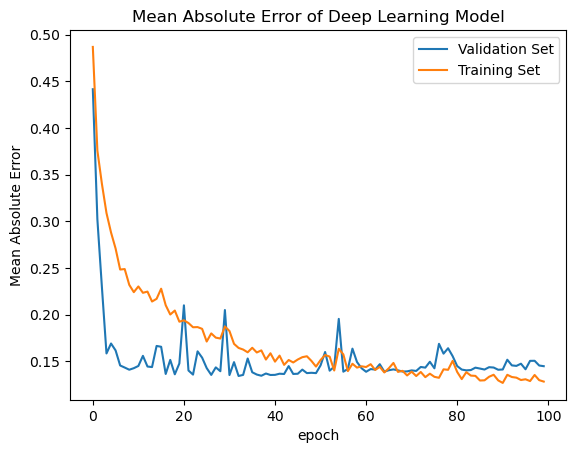

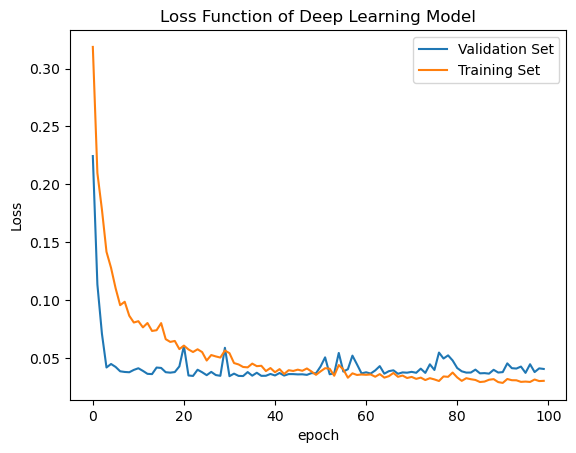

In [111]:
# summarize history for accuracy
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error of Deep Learning Model')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['Validation Set','Training Set',], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss Function of Deep Learning Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Validation Set','Training Set'], loc='upper right')
plt.show()

#### Predict Results using Your Model
Here we use our test data again, but you'd likely want to apply this to other data.
The inputs (and thier format) must match the model that you trained above. 
  
Below we provide some plots and summary statistics for evaluating true vs predicted values.  
Try to create a model better than ours!

In [33]:
# make a prediction
predict = model.predict([np.array(X_test['transcriptomics'].tolist()),
     np.array(X_test['proteomics'].tolist()),
     np.array(X_test['fingerprint'].tolist())
    ])

4/4 [==============================] - 0s 1ms/step


In [93]:
new_df = pd.DataFrame({
    'Predicted Values': predict["priority"].tolist(),
    'True Values': y_test
})
new_df['Predicted Values'] = new_df['Predicted Values'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
sorted_df = new_df.sort_values(by='True Values', ascending=True)  # Change 'ascending' to False for descending order
sorted_df

,Predicted Values,True Values
830,0.689598,0.0000
198,0.613777,0.3066
10,0.576904,0.3380
355,0.569279,0.3572
656,0.576972,0.4010
...,...,...
485,0.907541,0.9939
371,0.961458,0.9997
323,0.957583,1.0000
430,0.911885,1.0000


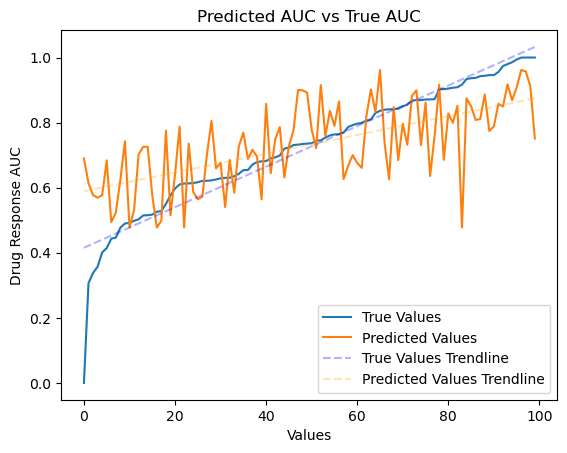

In [113]:
true_values = np.array(sorted_df["True Values"])
predicted_values = np.array(sorted_df["Predicted Values"])

# Plot the true values and predicted values
plt.plot(true_values)
plt.plot(predicted_values)

# Fit trendlines
true_values_trendline = LinearRegression().fit(np.arange(len(true_values)).reshape(-1, 1), true_values.reshape(-1, 1)).predict(np.arange(len(true_values)).reshape(-1, 1))
predicted_values_trendline = LinearRegression().fit(np.arange(len(predicted_values)).reshape(-1, 1), predicted_values.reshape(-1, 1)).predict(np.arange(len(predicted_values)).reshape(-1, 1))

# Plot trendlines
plt.plot(true_values_trendline, linestyle='--', color='blue', alpha=0.3)
plt.plot(predicted_values_trendline, linestyle='--', color='orange', alpha=0.3)

# Customize plot
plt.title('Predicted AUC vs True AUC')
plt.ylabel('Drug Response AUC')
plt.xlabel('Values')
plt.legend(['True Values', 'Predicted Values', 'True Values Trendline', 'Predicted Values Trendline'], loc='lower right')
plt.show()

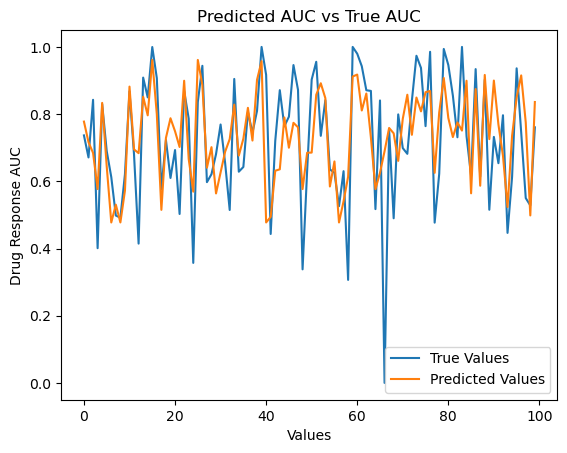

In [112]:
true_values = np.array(new_df["True Values"])
predicted_values = np.array(new_df["Predicted Values"])

# Plot the true values and predicted values
plt.plot(true_values)
plt.plot(predicted_values)

# Fit trendlines
true_values_trendline = LinearRegression().fit(np.arange(len(true_values)).reshape(-1, 1), true_values.reshape(-1, 1)).predict(np.arange(len(true_values)).reshape(-1, 1))
predicted_values_trendline = LinearRegression().fit(np.arange(len(predicted_values)).reshape(-1, 1), predicted_values.reshape(-1, 1)).predict(np.arange(len(predicted_values)).reshape(-1, 1))


# Customize plot
plt.title('Predicted AUC vs True AUC')
plt.ylabel('Drug Response AUC')
plt.xlabel('Values')
plt.legend(['True Values', 'Predicted Values', 'True Values Trendline', 'Predicted Values Trendline'], loc='lower right')
plt.show()

In [102]:
# Calculate Summary Statistics


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(new_df['True Values'], new_df['Predicted Values'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(new_df['True Values'], new_df['Predicted Values']))

# Calculate R-squared (R2) score
r2 = r2_score(new_df['True Values'], new_df['Predicted Values'])

summary_statistics = new_df.describe()

# Print the statistics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("\n")
# Print summary statistics
print(summary_statistics)

Mean Absolute Error (MAE): 0.11160688844966887
Root Mean Squared Error (RMSE): 0.14780030079805684
R-squared (R2) Score: 0.37366931237133216


       Predicted Values  True Values
count        100.000000   100.000000
mean           0.731800     0.723970
std            0.128604     0.187696
min            0.477577     0.000000
25%            0.639343     0.616050
50%            0.733571     0.736050
75%            0.838911     0.869575
max            0.961458     1.000000


In [108]:
#Side by side comparison for first 50 values.
new_df[0:50]

,Predicted Values,True Values
918,0.777755,0.7367
525,0.716599,0.6711
567,0.684600,0.8426
656,0.576972,0.4010
915,0.833463,0.8296
429,0.644341,0.6900
855,0.477577,0.6126
711,0.530543,0.4982
174,0.477577,0.4917
604,0.572155,0.6209


### Good luck creating your own Model!